## MalConv2 Model Execution
This section demonstrates how to load and run the MalConv2 model using the instructions and files from the `MalConv2-main` directory. Code is based on the README instructions.

In [ ]:
import sys
import os
import torch
import numpy as np
import torch.nn.functional as F

# 경로 설정 유연성 확보 (Notebook 실행 위치에 따라 경로가 다를 수 있음)
# MalConv2-main 폴더 찾기
current_dir = os.getcwd()
possible_paths = [
    os.path.join(current_dir, 'MalConv2-main'),         # 작업 설정이 루트일 경우
    os.path.join(current_dir, '../models/MalConv2-main'),      # 작업 설정이 현재 파일 위치(test/)일 경우
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main' # 절대 경로 (fallback)
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path:
        sys.path.append(malconv_path)
    print(f"MalConv2-main path added: {malconv_path}")
else:
    print("Error: Could not find MalConv2-main directory.")

# src 폴더 경로 추가 (preprocess.py 사용을 위해)
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path:
    sys.path.append(src_path)

try:
    # MalConvGCT 및 전처리 함수 임포트
    from MalConvGCT_nocat import MalConvGCT
    from src import preprocess_pe_file
    print("Successfully imported MalConvGCT and preprocess_pe_file")

    # 모델 초기화 (README의 파라미터 참고)
    # channels=256, window_size=256, stride=64 설정
    channels = 256
    window_size = 256
    stride = 64
    embd_size = 8
    
    print("Initializing model...")
    model = MalConvGCT(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)
    
    # 체크포인트 로드
    checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
    
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        # Mac M2(Apple Silicon) 호환성을 위해 map_location='cpu' 사용 권장
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        
        # 가중치 로드
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print("Model weights loaded successfully.")
        else:
            print(f"Warning: 'model_state_dict' not found. Keys: {checkpoint.keys()}")
    else:
        print(f"Warning: Checkpoint file not found at {checkpoint_path}. Running with random weights.")

    # 모델을 평가 모드로 설정
    model.eval()

    # 실제 파일 전처리 및 실행 테스트
    target_file = 'ZoomInstaller.exe'
    
    # 파일 존재 여부 확인 후 진행
    if os.path.exists(target_file):
        print(f"Processing file: {target_file}")
        
        # preprocess_pe_file 함수를 사용하여 입력 데이터 준비
        # mode='default' 사용
        input_tensor = preprocess_pe_file(target_file, mode='default')
        
        print(f"Running inference on input with shape {input_tensor.shape}...")
        
        with torch.no_grad():
            output = model(input_tensor)
            # MalConvGCT returns: (logits, penult, post_conv)
            logits = output[0]
            probabilities = F.softmax(logits, dim=1)
            
        print("\nExecution Complete!")
        print(f"Logits: {logits}")
        
        # 결과 해석
        print("\n[결과 해석]")
        print(f"1. Logits (Raw Score): {logits.tolist()}")
        print(f"2. Probabilities (Softmax): {probabilities.tolist()}")
        print(f"   - Class 0 (Benign/정상): {probabilities[0][0].item():.4f} ({probabilities[0][0].item()*100:.2f}%)")
        print(f"   - Class 1 (Malware/악성): {probabilities[0][1].item():.4f} ({probabilities[0][1].item()*100:.2f}%)")
        
        predicted_class = torch.argmax(probabilities, dim=1).item()
        class_label = "악성 (Malware)" if predicted_class == 1 else "정상 (Benign)"
        print(f"3. 최종 예측: {class_label} (Class {predicted_class})")
        
    else:
        print(f"Error: Target file '{target_file}' not found. Please make sure the file exists in the current directory.")

except ImportError as e:
    print(f"Import Error: {e}")
    print("Make sure MalConv2-main is in the path and src package is accessible.")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Config 로드 테스트
from src.utils import load_config
try:
    config = load_config()
    print("Config loaded successfully:")
    print(config)
except Exception as e:
    print(f"Failed to load config: {e}")

In [ ]:
# MalConvGCTDeepShap Class Test
import sys
import os
import torch
import matplotlib.pyplot as plt

print("\n--- Testing MalConvGCTDeepShap ---")

# 1. Path Setup (경로 설정)
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path: sys.path.append(src_path)

# MalConv2-main 폴더 찾기
possible_paths = [
    os.path.join(current_dir, '../models/MalConv2-main'),
    os.path.join(current_dir, 'MalConv2-main'),
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main'
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path: sys.path.append(malconv_path)
    print(f"Model path found: {malconv_path}")
else:
    print("Warning: MalConv2-main path not found. Imports might fail.")

# Import modules
from src.compute_DeepShap import MalConvGCTDeepShap
from src import preprocess_pe_file

# 2. Initialize Model (모델 초기화)
# Default parameters as per README/previous cells
channels = 256
window_size = 256
stride = 64
embd_size = 8

print("Initializing MalConvGCTDeepShap model...")
new_model = MalConvGCTDeepShap(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)

# 3. Load Checkpoint (체크포인트 로드)
# 이전 셀 실행 여부와 관계없이 직접 체크포인트를 로드합니다.
if malconv_path:
    checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        try:
            # Map location to CPU for compatibility
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            
            if 'model_state_dict' in checkpoint:
                # strict=False allows loading even if some auxiliary keys differ, but usually should match
                new_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
                print("Checkpoint loaded successfully.")
            else:
                 new_model.load_state_dict(checkpoint, strict=False)
                 print("Checkpoint loaded successfully (direct state dict).")
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")
    else:
        print(f"Checkpoint file NOT found at: {checkpoint_path}")
else:
    print("Cannot look for checkpoint because model directory was not found.")

new_model.eval()

# 4. Prepare Input (입력 데이터 준비)
# 파일이 있으면 로드, 없으면 랜덤 (테스트용)
target_file = 'ZoomInstaller.exe'
input_tensor = None

if os.path.exists(target_file):
    print(f"Loading target file: {target_file}")
    try:
        input_tensor = preprocess_pe_file(target_file, mode='default')
        print(f"Input loaded. Shape: {input_tensor.shape}")
    except Exception as e:
        print(f"Error processing file: {e}")
else:
    print(f"Target file '{target_file}' not found.")

if input_tensor is None:
    print("Warning: Using random input tensor (fallback). SHAP values might be zero or meaningless.")
    input_tensor = torch.randint(0, 256, (1, 200000)).long()

# 5. Forward Pass with SHAP
print("Executing forward pass (predict + explain)...")
try:
    # Model returns: (logits, penult, post_conv, shap_context, shap_feature)
    outputs = new_model(input_tensor)
    
    if len(outputs) == 5:
        logits, penult, post_conv, shap_context, shap_feature = outputs
        
        print("\n[Execution Successful]")
        print(f"Logits: {logits.detach().cpu().numpy()}")
        
        # Calculate Probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)
        print(f"Probabilities: {probs.detach().cpu().numpy()}")
        
        # Basic Statistics
        print("\n[SHAP Statistics]")
        print(f"Context SHAP - Max: {np.max(shap_context):.6f}, Min: {np.min(shap_context):.6f}, Sum: {np.sum(shap_context):.6f}")
        print(f"Feature SHAP - Max: {np.max(shap_feature):.6f}, Min: {np.min(shap_feature):.6f}, Sum: {np.sum(shap_feature):.6f}")

        # Visualization
        plt.figure(figsize=(12, 8))
        
        # Display first N bytes
        view_len = min(50000, len(shap_context))
        x_axis = range(view_len)
        
        plt.subplot(2, 1, 1)
        plt.plot(x_axis, shap_context[:view_len], label='Context DeepSHAP', color='royalblue', linewidth=0.6)
        plt.title(f'Context SHAP Values (First {view_len} bytes)')
        plt.ylabel('Contribution')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(x_axis, shap_feature[:view_len], label='Feature DeepSHAP', color='crimson', linewidth=0.6)
        plt.title(f'Feature SHAP Values (First {view_len} bytes)')
        plt.ylabel('Contribution')
        plt.xlabel('Byte Index')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Unexpected output length: {len(outputs)}. Output structure might have changed.")
        
except Exception as e:
    print(f"Error during execution: {e}")
    import traceback
    traceback.print_exc()



--- Testing MalConvGCTDeepShap on All Metadata Files ---
Initializing MalConvGCTDeepShap model...
Loading checkpoint from: /Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main/malconvGCT_nocat.checkpoint
Found 7 files in /Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/test/../data

[1/7] Processing: Win32.MyLobot.bin
[21:44:06] INFO  : DeepSHAP explanation computed for both Context and Feature.
  Result: Malware Prob = 100.00%


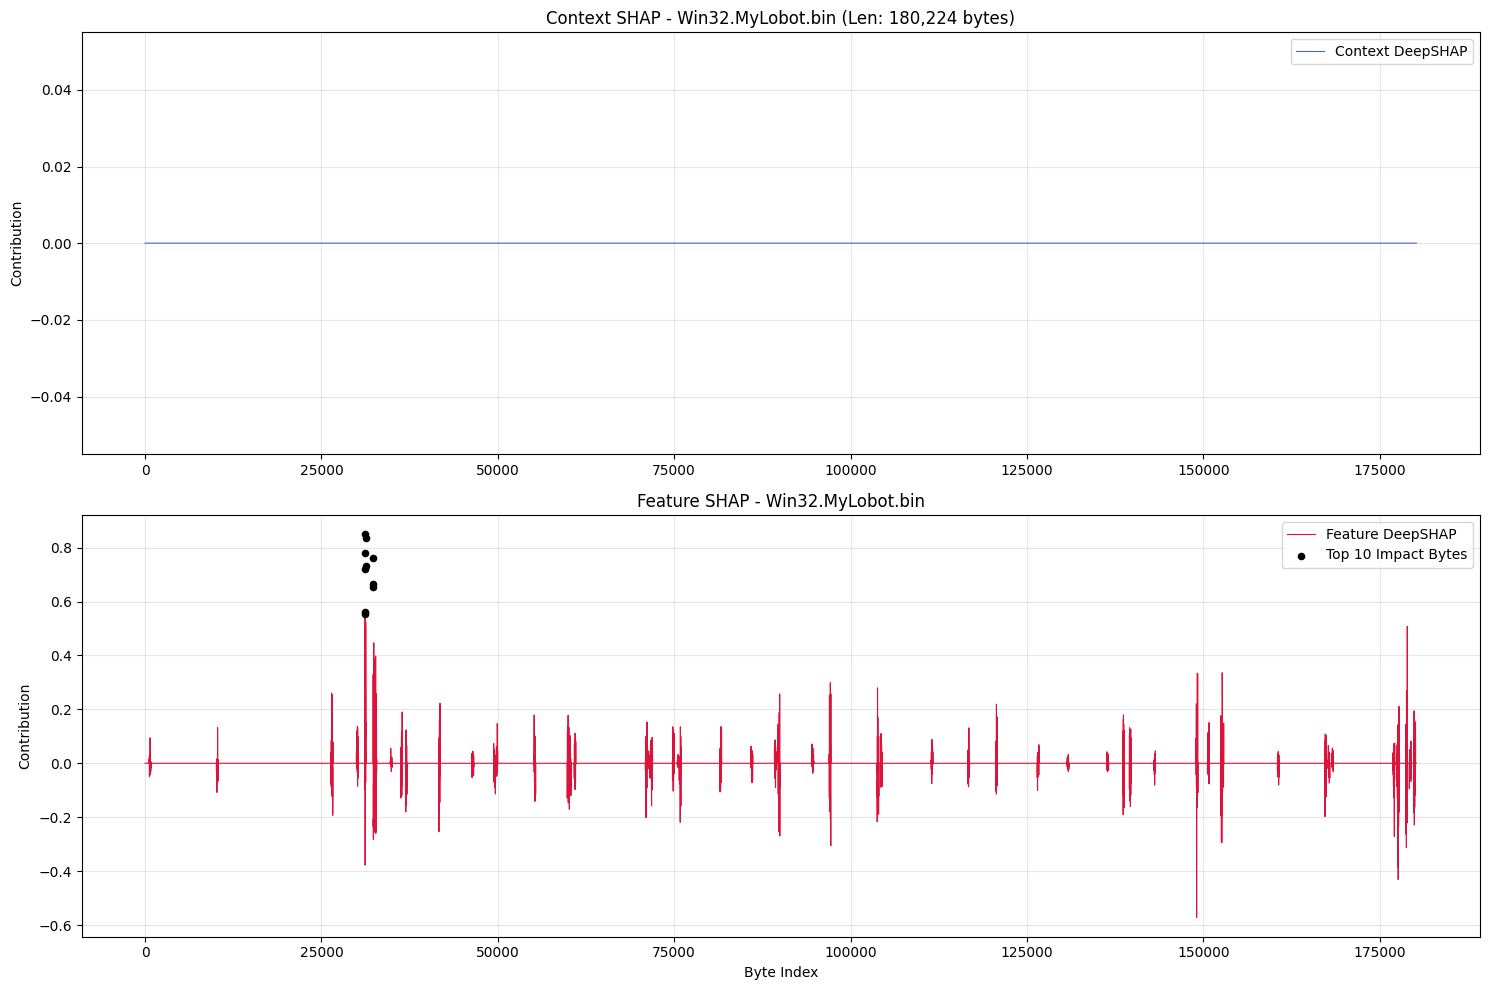

  Top 10 Impactful Byte Indices (sorted by impact): [31196 31256 31208 32336 31278 31175 32356 32360 31211 31185]

[2/7] Processing: win32_emotet.bin
[21:44:06] INFO  : DeepSHAP explanation computed for both Context and Feature.
  Result: Malware Prob = 98.31%


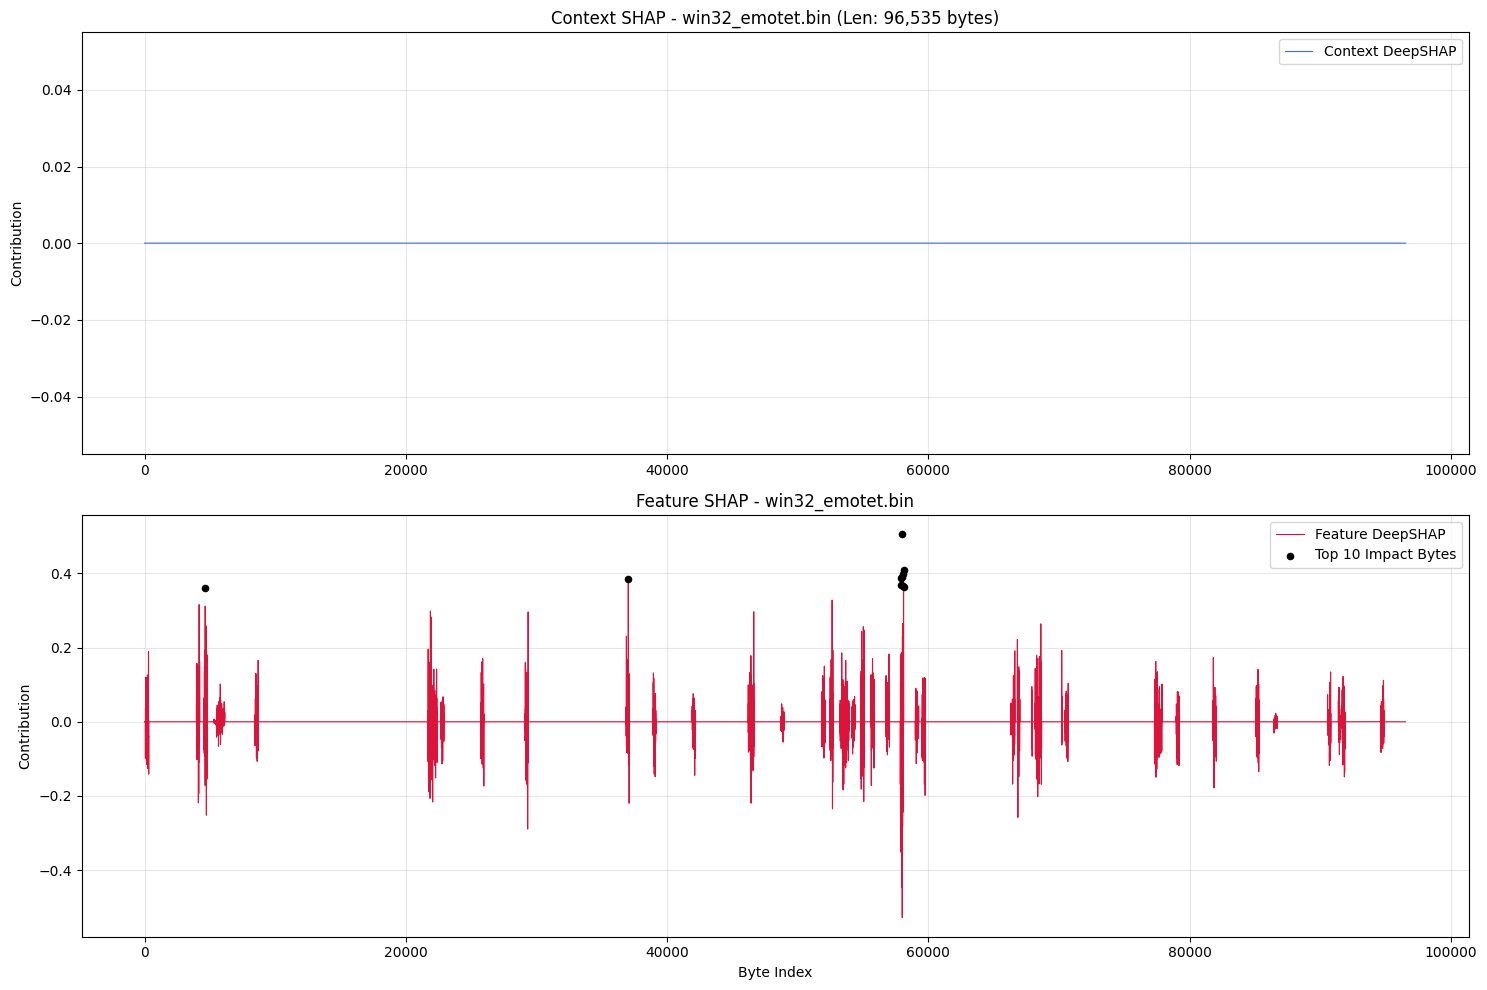

  Top 10 Impactful Byte Indices (sorted by impact): [58018 58104 58042 58023 57874 37032 57910 58094 58100  4614]

[3/7] Processing: Win32.SofacyCarberp.exe
[21:44:06] INFO  : DeepSHAP explanation computed for both Context and Feature.
  Result: Malware Prob = 99.14%


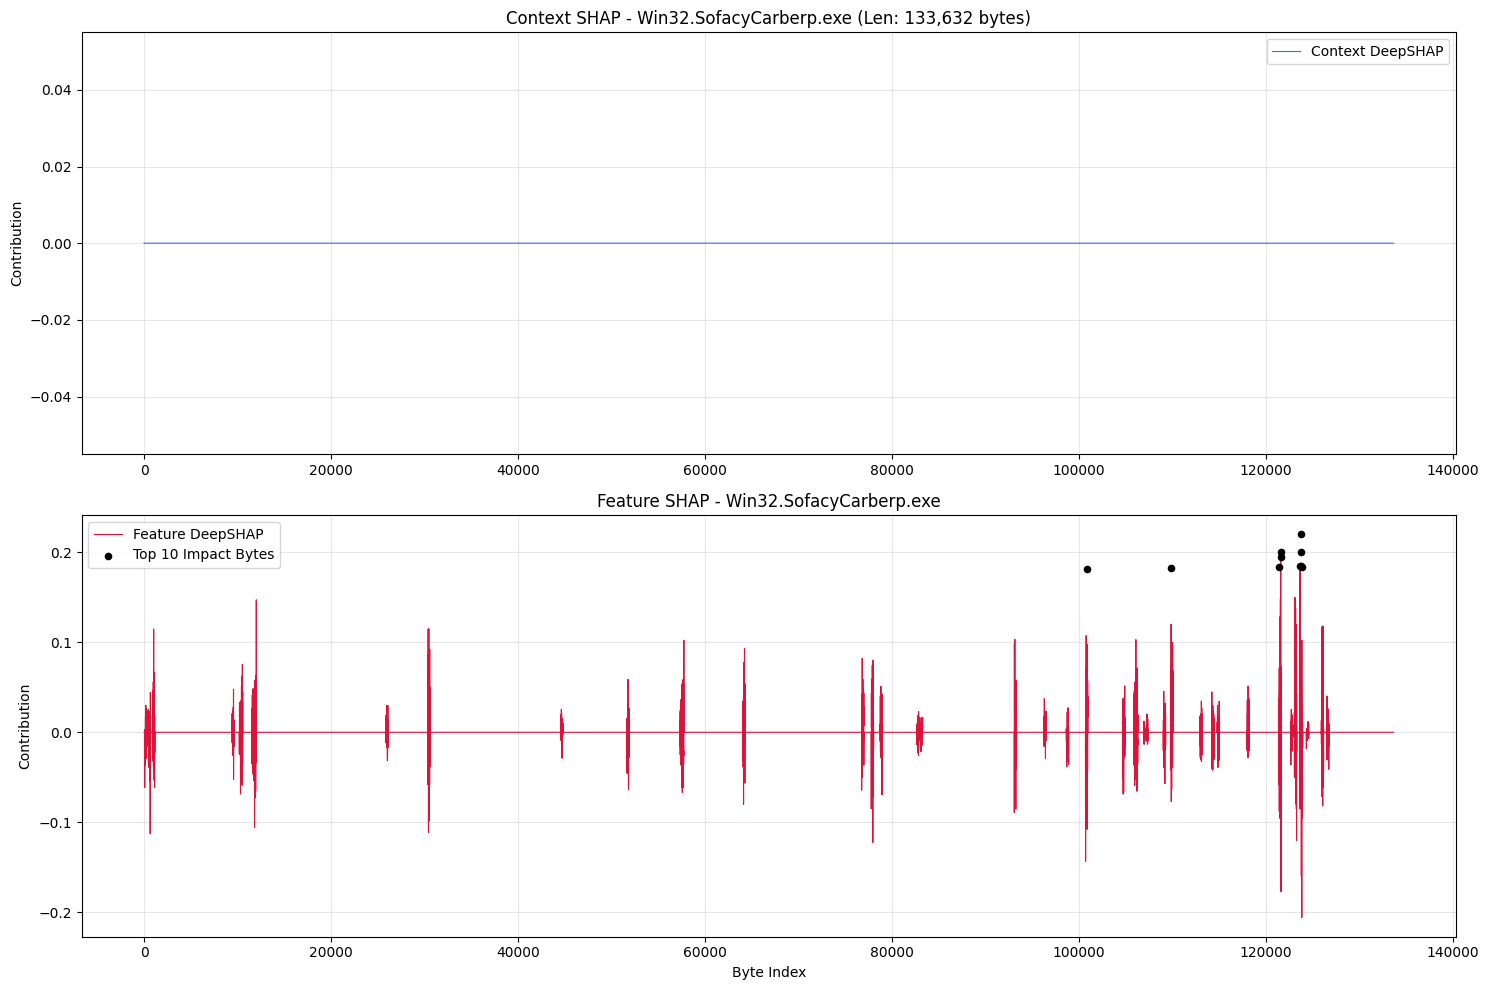

  Top 10 Impactful Byte Indices (sorted by impact): [123703 123689 121568 121554 123686 123612 123808 121402 109774 100786]

[4/7] Processing: Ransomware.WannaCry.exe


In [ ]:
# MalConvGCTDeepShap APK/PE File Test (Improved Vis) - Iterating over Data Folder
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Testing MalConvGCTDeepShap on All Metadata Files ---")

# 1. Path Setup
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path: sys.path.append(src_path)

# MalConv2-main Path
possible_paths = [
    os.path.join(current_dir, '../models/MalConv2-main'),
    os.path.join(current_dir, 'MalConv2-main'),
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main'
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path: sys.path.append(malconv_path)
    # print(f"Model path found: {malconv_path}")
else:
    print("Warning: MalConv2-main path not found. Imports might fail.")

# Import modules
from src.compute_DeepShap import MalConvGCTDeepShap
from src import preprocess_pe_file
# Decrease logging noise

# 2. Initialize Model
channels = 256
window_size = 256
stride = 64
embd_size = 8

print("Initializing MalConvGCTDeepShap model...")
new_model = MalConvGCTDeepShap(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)

# 3. Load Checkpoint
if malconv_path:
    checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            if 'model_state_dict' in checkpoint:
                new_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
                # print("Checkpoint loaded successfully.")
            else:
                 new_model.load_state_dict(checkpoint, strict=False)
                 # print("Checkpoint loaded successfully (direct state dict).")
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")
            sys.exit(1)
    else:
        print(f"Checkpoint file NOT found at: {checkpoint_path}")
        sys.exit(1)

new_model.eval()

# 4. Prepare Data Iterator
data_dir_candidates = [
    os.path.join(current_dir, '../data'),
    os.path.join(current_dir, 'data'),
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/data'
]

data_dir = None
for d in data_dir_candidates:
    if os.path.exists(d) and os.path.isdir(d):
        data_dir = d
        break

if not data_dir:
    print("Data directory not found!")
    files_to_process = []
else:
    files_to_process = [f for f in os.listdir(data_dir) if not f.startswith('.')]
    print(f"Found {len(files_to_process)} files in {data_dir}")

# 5. Process Each File
for idx, filename in enumerate(files_to_process):
    file_path = os.path.join(data_dir, filename)
    print(f"\n[{idx+1}/{len(files_to_process)}] Processing: {filename}")
    
    # Check File Header
    try:
        with open(file_path, 'rb') as f:
            header = f.read(2)
            if header != b'MZ':
                 print(f"  Warning: File Header is {header}, not 'MZ'. May affect results.")
    except Exception as e:
        print(f"  Error reading file: {e}")
        continue

    # Preprocess
    try:
        input_tensor = preprocess_pe_file(file_path, mode='default')
    except Exception as e:
        print(f"  Error preprocessing: {e}")
        continue

    # Forward Pass & SHAP
    try:
        outputs = new_model(input_tensor)
        
        if len(outputs) == 5:
            logits, penult, post_conv, shap_context, shap_feature = outputs
            
            probs = torch.nn.functional.softmax(logits, dim=1)
            p_malware = probs[0][1].item()
            
            print(f"  Result: Malware Prob = {p_malware*100:.2f}%")
            
            # --- Visualization ---
            plt.figure(figsize=(15, 10))
            
            # Downsampling
            total_len = len(shap_feature)
            step = max(1, total_len // 20000)
            x_axis = range(0, total_len, step)
            
            # 1. Context SHAP
            plt.subplot(2, 1, 1)
            plt.plot(x_axis, shap_context[::step], label='Context DeepSHAP', color='royalblue', linewidth=0.8)
            plt.title(f'Context SHAP - {filename} (Len: {total_len:,} bytes)')
            plt.ylabel('Contribution')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            # 2. Feature SHAP
            plt.subplot(2, 1, 2)
            plt.plot(x_axis, shap_feature[::step], label='Feature DeepSHAP', color='crimson', linewidth=0.8)
            
            # Highlight Top 10 Regions
            top_k = 10
            top_idx = np.argsort(shap_feature)[-top_k:] # Top 10
            # Sort indices for better readability in print
            top_idx_sorted_by_val = top_idx[::-1] 
            
            plt.scatter(top_idx, shap_feature[top_idx], color='black', zorder=5, s=20, label=f'Top {top_k} Impact Bytes')
            
            plt.title(f'Feature SHAP - {filename}')
            plt.ylabel('Contribution')
            plt.xlabel('Byte Index')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            print(f"  Top {top_k} Impactful Byte Indices (sorted by impact): {top_idx_sorted_by_val}")
            
        else:
            print("  Unexpected output structure.")
            
    except Exception as e:
        print(f"  Error during model execution: {e}")
        import traceback
        traceback.print_exc()

print("\nAll files processed.")